In [1]:
%matplotlib inline
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer,Imputer
import pandas as pd
import matplotlib.pyplot as plt
try:
    import urllib2 # Python 2
except:
    import urllib.request as urllib2 # Python 3
import json
# Import neurotree api python functions
from neurotree_api import get_investigator_path_len, get_neurotree_node_id_from_pmid, get_neurotree_node_info
from sklearn.preprocessing import Imputer, StandardScaler
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import ShuffleSplit

Using Theano backend.


## Load data and test API

In [2]:
# Test NeuroTree website
base_api_url = 'http://neurotree.org/'
pmid = 11483306
query_url = "http://neurotree.org/beta/include/check_pmid.php?term=11483306"
response = urllib2.urlopen(query_url)

In [3]:
# Test the api functions
get_neurotree_node_info(4800)
node_id = get_neurotree_node_id_from_pmid(11483306)
get_investigator_path_len(77014, 4800)
get_investigator_path_len(2218, 196)

{'path2': [2715, 77014], 'name1': 'Shreejoy J Tripathy', 'stepcount': 2, 'backonly': '1', 'pathcount': 2, 'name2': 'Richard C Gerkin', 'stepstaken': 1, 'pid1': 77014, 'path1': [2715, 4800], 'pid2': 4800}
{'path2': None, 'name1': 'Daniel L Alkon', 'stepcount': None, 'backonly': '1', 'pathcount': None, 'name2': 'Claude  Bernard', 'stepstaken': 8, 'pid1': 2218, 'path1': None, 'pid2': 196}


(None, None)

In [4]:
# Load the NeuroTree distance file.  
with open('dist_mtx.txt','rb') as f:
    dist_data = json.loads(f.read().decode('latin1'))
    
# Parse the NeuroTree distance file into a matrix.  
nt_ancestors = list(set([x['p0'] for x in dist_data])) # Extract ancestor list
nt_regulars = list(set([x['p1'] for x in dist_data]).union(set([x['p2'] for x in dist_data]))) # Extract regular list.  
n_regulars = len(nt_regulars) # Number of regulars.
dist_matrix = -1.0 * np.ones((n_regulars,n_regulars)) # Matrix of distances, filled with -1 (no path).  
for entry in dist_data: # Iterate over entries in the distance data.  
    p0,p1,p2,d = [entry[i] for i in ['p0','p1','p2','d']]
    d = np.inf if d=='-1' else int(d)
    x1 = nt_regulars.index(p1) # Matrix index of individual with id p1.  
    x2 = nt_regulars.index(p2) # Matrix index of individual with id p2.  
    dist_matrix[x1,x2] = d # Set forward distance to d.  
    dist_matrix[x2,x1] = d # Set reverse distance to d (for symmetry).  
for i in range(n_regulars): # For each individual.  
    dist_matrix[i,i] = 0 # Set the diagonal entry (self distance) to 0.  

In [5]:
# Load the NeuroTree fingerprint file.  
with open('fingerprint_mtx.txt','rb') as f:
    fp_data = json.loads(f.read().decode('latin1'))
    
# Parse the NeuroTree fingerprint file into a matrix.  
ancestors = list(set([x['p0'] for x in fp_data])) # Extract ancestor list
regulars = list(set([x['p1'] for x in fp_data])) # Extract list of key nodes
key_nodes = list(set([x['p2'] for x in fp_data])) # Extract list of key nodes
n_regulars = len(regulars) # Number of regulars
n_key_nodes = len(key_nodes) # Number of key nodes
fp_matrix = np.inf * np.ones((n_regulars,n_key_nodes)) # Matrix of distances, filled with -1 (no path).  
for entry in fp_data: # Iterate over entries in the distance data.  
    p0,p1,p2,d = [entry[i] for i in ['p0','p1','p2','d']]
    d = np.inf if d=='-1' else int(d)
    x1 = regulars.index(p1) # Matrix index of individual with id p1.  
    x2 = key_nodes.index(p2) # Matrix index of individual with id p2.  
    fp_matrix[x1,x2] = d # Set distance to d.  
fp_matrix[np.isinf(fp_matrix)] = 30
fp_df = pd.DataFrame(fp_matrix,index=regulars,columns=key_nodes)

In [6]:
# Load the neuroelectro data dump.  
df = pd.read_csv('http://dev.neuroelectro.org/static/src/article_ephys_metadata_curated.csv',delimiter='\t')

## Create a linkage and similarity matrix from the path lengths.

In [7]:
# Sort the pairwise path length matrix by similarity
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import leaders, fclusterdata, linkage, dendrogram, leaves_list

d = squareform(dist_matrix, checks = False)
Z = linkage(d)
sorted_rows = leaves_list(Z)

sorted_nt_regulars = [nt_regulars[i] for i in sorted_rows.tolist()]
try:
    none_index = sorted_nt_regulars.index(None)
except ValueError:
    has_none_index = False
else:
    has_none_index = True
    del sorted_nt_regulars[none_index]

sorted_author_names = [get_neurotree_node_info(int(node_id)) for node_id in sorted_nt_regulars]
sorted_author_last_names = []
for n in sorted_author_names:
    if n and 'lastname' in n:
        sorted_author_last_names.append('%s, %s' % (n['lastname'], n['pid']))
    else:
        sorted_author_last_names.append('UNKN')

# sym_path_len_mat_sorted is the sorted path length distance matrix
elems = sorted_rows.tolist()
if has_none_index:
    del elems[none_index]

new_order = elems
dist_matrix_sorted = dist_matrix[:, new_order][new_order]

In [8]:
# Define a data frame for the symmetric path length distance matrix
path_df = pd.DataFrame(data = dist_matrix_sorted, index = sorted_nt_regulars, columns = sorted_nt_regulars)
sorted_author_last_names_df = pd.DataFrame(data = sorted_author_last_names, index = sorted_nt_regulars, columns = ['names'])

In [9]:
# Map neuroelectro pubmed ids to neurotree node ids
neurotree_id_list = []
cell_type_name = 'Hippocampus CA1 pyramidal cell'
ca1_df = df[df['NeuronName'].isin([cell_type_name])]
ca1_df.head()

cell_match = df['NeuronName'].isin([cell_type_name])
pmid_list = list(set(df['Pmid'][cell_match]))
df.loc[:,'NeuroTreeID'] = np.zeros(len(df['Pmid']))
pmid_to_node_dict = {}

for index, row in ca1_df.iterrows():
    pmid = row['Pmid']
    node_id = get_neurotree_node_id_from_pmid(pmid)
    ca1_df.loc[index,'NeuroTreeID'] = node_id

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
# Create a new data frame summarizing neurotree node info and neuroelectro pub info
new_df = ca1_df[['NeuroTreeID', 'LastAuthor', 'Pmid']]
new_df = new_df.drop_duplicates(['NeuroTreeID', 'LastAuthor'])

new_df.sort_values(by = ['NeuroTreeID', 'LastAuthor'])

new_df.loc[:,'Connectedness'] = np.empty(len(new_df['Pmid']))
new_df.loc[:,'Connectedness'] = np.NAN
new_df.head()

for index, row in new_df.iterrows():
    pid = row['NeuroTreeID']
    if pid in path_df.columns:
        num_inf = sum(path_df[pid].values == np.inf) + sum(np.isnan(path_df[pid].values))
        
        pct_inf = num_inf / (float(len(path_df.columns)) - 1)
        new_df.loc[index,'Connectedness'] = 1 - pct_inf
    else:
        new_df.loc[index,'Connectedness'] = np.nan

new_df = new_df.sort_values(by = ['Connectedness', 'NeuroTreeID', 'LastAuthor'], ascending = [0, 1, 1])
new_df.to_csv('ca1_pyr_auths.csv', index = False)

In [11]:
# Define a data frame min_df as a cleaned data frame of the path length matrix between neurotree node ids
inds = new_df[new_df['Connectedness'] > .2]['NeuroTreeID']
valid_pmids = new_df[new_df['Connectedness'] > .2]['Pmid']
keep_inds = path_df.index.isin(inds)

min_df = path_df.loc[keep_inds,keep_inds]
min_df[min_df > 20] = 20
min_df[np.isnan(min_df)] = 20

names = sorted_author_last_names_df.ix[keep_inds, 'names'].values

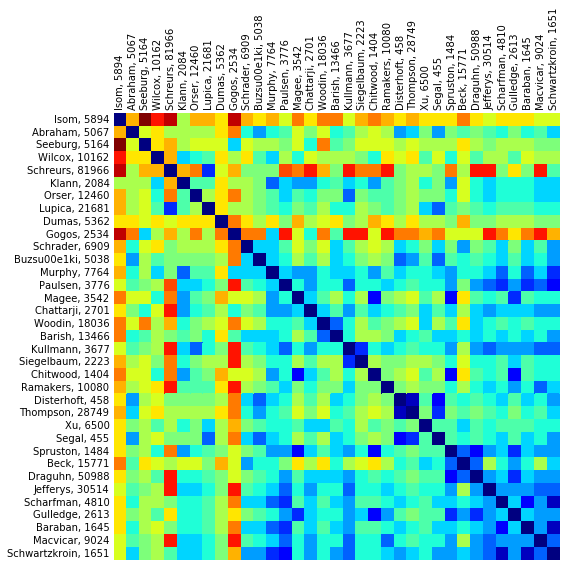

In [12]:
# Plot the pairwise matrix of neurotree minimum path lengths
fig, ax = plt.subplots()
heatmap = ax.pcolor(min_df)
fig = plt.gcf()
fig.set_size_inches(8, 8)

ax.set_frame_on(False) # Turn off the frame
ax.set_yticks(np.arange(min_df.shape[0]) + 0.5, minor=False) # add major ticks
ax.set_xticks(np.arange(min_df.shape[1]) + 0.5, minor=False)
ax.invert_yaxis() # Want a more natural, table-like display
ax.xaxis.tick_top()
labels = names
ax.set_xticklabels(labels, minor=False)
ax.set_yticklabels(labels, minor=False)
plt.xticks(rotation=90)
ax.grid(False)
ax = plt.gca() # Turn off all the ticks

for t in ax.xaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False
for t in ax.yaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False

## Build matrices and do prediction

In [13]:
y_var_names = ['rin','rmp','apthr','apamp','aphw','tau','ahpamp'] 

In [14]:
def build_y():
    # Define a matrix composed of CA1 publication ephys values
    ndf = ca1_df[y_var_names]
    has_non_na_y_vals = ndf[y_var_names].isnull().all(axis=1)
    ndf.loc[has_non_na_y_vals,'rin'] = 100
    #print(ndf.loc[has_non_na_y_vals]['rin'])
    y_matrix = ndf.as_matrix()
    #imputer = Imputer(strategy='median',axis=0)
    biscaler = BiScaler(center_rows = False, scale_rows = False)
    standardscaler = StandardScaler()
    y_scaled = biscaler.fit_transform(y_matrix) # Center and scale columns to unit variance
    y_imputed = KNN(k=3).complete(y_scaled)

    # The final y matrix of ephys values
    y_df = pd.DataFrame(y_imputed, index = ca1_df.index)
    return y_df,y_imputed,y_scaled

y_df,y_imputed,y_scaled = build_y()

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[BiScaler] Initial log residual value = 10.139585
[BiScaler] Iter 1: log residual = -68.520577, log improvement ratio=78.660162
[BiScaler] Iter 2: log residual = -68.520577, log improvement ratio=0.000000
Computing pairwise distances between 133 samples
Computing distances for sample #1/133, elapsed time: 0.000
Computing distances for sample #101/133, elapsed time: 0.003
Imputing row 1/133 with 3 missing columns, elapsed time: 0.004
Imputing row 101/133 with 2 missing columns, elapsed time: 0.008
[KNN] Warning: 8/931 still missing after imputation, replacing with 0


In [15]:
def build_x(ca1_df,min_df,fp_df,include_neurotree=False):
    # Now getting back to the analysis of the neuroelectro data
    # Define a matrix composed of CA1 publication metadata values
    # Uses ca1_df defined above, a subset of the neuroelectro data import
    
    # include_neurotree=False: don't use it
    # include_neurotree='min': use the distances to the well-connected nodes
    # include_neurotree='fp': use the fingerprint matrix
    assert include_neurotree in [False,'min','fp']
    
    from sklearn.preprocessing import Imputer, StandardScaler
    from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute
    imputer = Imputer(strategy='median',axis=0)
    biscaler = BiScaler(center_rows = False, scale_rows = False)
    standardscaler = StandardScaler()

    x_features = ['Species','Strain','ElectrodeType',
                'PrepType','JxnPotential','JxnOffset','RecTemp','AnimalAge','AnimalWeight',
                #'PubYear', 
                'external_0_Mg','external_0_Ca','external_0_Na','external_0_Cl','external_0_K',
                'external_0_pH','internal_0_Mg',
                'internal_0_Ca','internal_0_Na','internal_0_Cl','internal_0_K','internal_0_pH',]

    if include_neurotree:
        x_features += ['NeuroTreeID']

    x_df = ca1_df[x_features]
    x_df.loc[:,'AnimalAge'] = np.log10(x_df[['AnimalAge']])
    x_df.loc[:,'JxnOffset'] = np.abs(x_df[['JxnOffset']])
    
    if include_neurotree == 'min':
        x_features += list(min_df) # Add the path lengths to the well-connected nodes.  
        for f in list(min_df):
            vec = np.zeros(len(x_df['NeuroTreeID']))
            for i in range(len(vec)):
                nt_id = x_df['NeuroTreeID'].iloc[i]
                if (nt_id is not None) and (nt_id in list(path_df)):
                    vec[i] = path_df.loc[nt_id,f]
                    if vec[i] == np.inf:
                        vec[i] = 99
                else:
                    vec[i] = np.nan
            x_df[f] = vec
            
    if include_neurotree == 'fp':
        x_features += list(fp_df) # Add the path lengths to the well-connected nodes.  
        for f in list(fp_df):
            vec = np.zeros(len(x_df['NeuroTreeID']))
            for i in range(len(vec)):
                nt_id = x_df['NeuroTreeID'].iloc[i]
                if (nt_id is not None) and (nt_id in fp_df.index):
                    vec[i] = fp_df.loc[nt_id,f]
                    if vec[i] == np.inf:
                        vec[i] = 99
                else:
                    vec[i] = np.nan
            x_df[f] = vec

    # Replace columns of the feature matrix that contain labels (i.e. words) with columns
    # of indicator variables.  Also re-encode NaNs.  
    x_clean = None
    new_features = []
    for f in x_features:
        mlb = None
        col = x_df[f].as_matrix().copy()
        try:
            new_cols = col.astype('float').reshape(-1,1)
        except ValueError:
            options = []
            for i in range(len(col)):
                if type(col[i]) is float:
                    col[i] = 'NaN'
                col[i] = col[i].split(', ')
                for option in col[i]:
                    options.append(option)
            options = list(set(options))
            mlb = MultiLabelBinarizer()
            new_cols = mlb.fit_transform(col)
        if x_clean is not None:
            x_clean = np.hstack((x_clean,new_cols))
        else:
            x_clean = new_cols
        if mlb is None:
            new_features += [f]
        else:
            new_features += ['%s_%s' % (f,mlb.classes_[i]) for i in range(new_cols.shape[1])]

    # center and scale columsn so they have unit variance
    x_scaled = biscaler.fit_transform(x_clean)
    x_imputed = KNN(k=3).complete(x_scaled)

    # the final data frame for metadata
    x_df = pd.DataFrame(x_imputed, index = ca1_df.index, columns = new_features)
    return x_df,x_imputed,new_features

In [16]:
def fit_model(y_imputed,y_scaled,x_imputed):
    # Predict ephys parameters using the solution/species metadata in x_matrix_df
    rfc = RandomForestRegressor(n_estimators=100,random_state=0)
    n_obs = y_imputed.shape[0]
    n_splits = 25
    n_props = len(y_var_names)
    ss = ShuffleSplit(n_obs,n_iter=n_splits,test_size=0.2,random_state=0)
    rs = np.zeros((n_props,n_splits))
    important = np.zeros((x_imputed.shape[1],n_splits))

    # Fit the model, using cross-validation with 'n_splits' train/test splits.  
    for i,(train,test) in enumerate(ss):
        rfc.fit(x_imputed[train,:],y_imputed[train,:])
        y_predict = rfc.predict(x_imputed[test,:])
        y_obs = y_scaled[test,:]
        y_obs = np.ma.array(y_obs,mask=np.isnan(y_obs))
        for j in range(n_props):
            rs[j,i] = np.ma.corrcoef(y_predict[:,j],y_obs[:,j])[0,1]
            important[:,i] = rfc.feature_importances_
    return rs,important

In [17]:
from neurotree_api import get_neurotree_node_info
def node2name(node):
    node = int(node)
    info = get_neurotree_node_info(node)
    return '%s %s' % (info['firstname'],info['lastname'])

In [18]:
def report(rs,important,new_features):
    # Mean out-of-sample correlation between predicted and actual ephys values
    for j,ephys_prop in enumerate(y_var_names):
        print('%s: %.2f +/- %.2f' % (ephys_prop,rs[j,:].mean(),rs[j,:].std()/np.sqrt(rs.shape[1])))

    # Top 10 most important features
    print('')
    important_ = important.mean(axis=1)
    ranks = range(len(important_))
    ranks = sorted(ranks,key=lambda x:important_[x],reverse=True)
    for k in range(1,11):
        feature = new_features[ranks[k]]    
        try:
            int(feature)
        except:
            pass
        else:
            feature = node2name(feature)
        print('%d) %s' % (k,feature)) # Mean correlation across hold-out samples))

In [19]:
# Build X matrices for various kinds of neurotree data
x_df_no,x_imputed_no,new_features_no = build_x(ca1_df,min_df,fp_df,include_neurotree=False)
x_df_min,x_imputed_min,new_features_min = build_x(ca1_df,min_df,fp_df,include_neurotree='min')
x_df_fp,x_imputed_fp,new_features_fp = build_x(ca1_df,min_df,fp_df,include_neurotree='fp')

[BiScaler] Initial log residual value = 13.848401
[BiScaler] Iter 1: log residual = -62.969691, log improvement ratio=76.818092
[BiScaler] Iter 2: log residual = -62.969691, log improvement ratio=0.000000
Computing pairwise distances between 133 samples
Computing distances for sample #1/133, elapsed time: 0.001
Computing distances for sample #101/133, elapsed time: 0.005
Imputing row 1/133 with 4 missing columns, elapsed time: 0.007
Imputing row 101/133 with 5 missing columns, elapsed time: 0.011
[BiScaler] Initial log residual value = 19.147026

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/ipykernel/__main__.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[BiScaler] Iter 1: log residual = -62.945448, log improvement ratio=82.092474
[BiScaler] Iter 2: log residual = -62.945448, log improvement ratio=0.000000
Computing pairwise distances between 133 samples
Computing distances for sample #1/133, elapsed time: 0.002
Computing distances for sample #101/133, elapsed time: 0.009
Imputing row 1/133 with 39 missing columns, elapsed time: 0.012
Imputing row 101/133 with 5 missing columns, elapsed time: 0.030
[BiScaler] Initial log residual value = 19.146937
[BiScaler] Iter 1: log residual = -62.928446, log improvement ratio=82.075382
[BiScaler] Iter 2: log residual = -62.928446, log improvement ratio=0.000000
Computing pairwise distances between 133 samples
Computing distances for sample #1/133, elapsed time: 0.001
Computing distances for sample #101/133, elapsed time: 0.008
Imputing row 1/133 with 54 missing columns, elapsed time: 0.011
Imputing row 101/133 with 5 missing columns, elapsed time: 0.030


In [20]:
# Fit the model that excludes neurotree data
rs,important = fit_model(y_imputed,y_scaled,x_imputed_no)
report(rs,important,new_features_no)

rin: 0.67 +/- 0.03
rmp: 0.58 +/- 0.04
apthr: 0.43 +/- 0.06
apamp: 0.69 +/- 0.02
aphw: 0.56 +/- 0.04
tau: 0.65 +/- 0.03
ahpamp: 0.49 +/- 0.07

1) JxnOffset
2) external_0_Ca
3) external_0_Mg
4) external_0_Cl
5) internal_0_Ca
6) internal_0_K
7) internal_0_pH
8) RecTemp
9) external_0_K
10) external_0_Na


In [21]:
# Fit the model that includes path lengths to min_df nodes (i.e. highly connected investigators)
rs,important = fit_model(y_imputed,y_scaled,x_imputed_min)
report(rs,important,new_features_min)

rin: 0.65 +/- 0.03
rmp: 0.57 +/- 0.04
apthr: 0.44 +/- 0.06
apamp: 0.68 +/- 0.03
aphw: 0.56 +/- 0.04
tau: 0.63 +/- 0.03
ahpamp: 0.39 +/- 0.08

1) JxnOffset
2) Heinz Beck
3) external_0_Mg
4) external_0_Ca
5) external_0_Cl
6) external_0_K
7) internal_0_Ca
8) external_0_Na
9) AnimalWeight
10) NeuroTreeID


In [22]:
# Fit the model that includes path lengths to fp_df nodes (i.e. the 50 fingerprint investigators)
rs,important = fit_model(y_imputed,y_scaled,x_imputed_fp)
report(rs,important,new_features_fp)

rin: 0.65 +/- 0.03
rmp: 0.56 +/- 0.04
apthr: 0.46 +/- 0.05
apamp: 0.68 +/- 0.03
aphw: 0.56 +/- 0.04
tau: 0.64 +/- 0.04
ahpamp: 0.44 +/- 0.08

1) JxnOffset
2) external_0_Mg
3) external_0_K
4) external_0_Ca
5) external_0_Cl
6) JxnPotential_NaN
7) external_0_Na
8) internal_0_K
9) NeuroTreeID
10) internal_0_Ca
